In [33]:
import mguaJN
import numpy as np
import sklearn
import pandas as pd
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
from sklearn.metrics import r2_score
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [293]:
from numpy import random

In [576]:
bzr = pd.read_csv('cox2/cox2_matrix_alphabet_NNdb*_UpTo2chains.csv', sep=',')
bzr_y = pd.read_csv('cox2/cox2_y.csv', sep=',')

In [577]:
bzr.head()

,Br1s*C3a*,C1d*C2d*,C1s*C2s*,C1s*C3a*,C1s*C3d*,C1s*C4s*,C1s*N2s*,C1s*N3a*,C1s*N3s*,C1s*O2s*,...,N2a*N2a*,N2a*N3a*,N2a*O2a*,N2s*S4w*,N3d*O1d*,N3d*O1s*,N3s*O2s*,N3s*S4w*,O1d*S3d*,O1d*S4w*
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [578]:
for i, elem in bzr_y['IC50_uM'].items():
    bzr_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [579]:
# bzr_y  = np.log(bzr_y+1)
bzr_y

,IC50_uM
0,0.06
1,0.51
2,10.2
3,0.06
4,0.08
...,...
462,0.093
463,0.005
464,0.1
465,0.02


## bzr

A set of 405 ligands for the benzodiazepine
receptor (BZR) has been assembled mostly from the work
of Haefely et al. and Cook et al. No differentiation of
agonists, antagonists, and inverse agonists is made. 
In vitro binding affinities as measured by inhibition
of [ 3 H] diazepam binding are expressed as IC 50 
values, ranging from 0.34 nM to >70 μM (65 compounds 
have indeterminate values). We have selected pIC_50=7.0
as the threshold for activity by considering a 
histogram plot of compound counts vs pIC_50 and the 
resulting balance of active and inactive compounds.

training, test, unused - set, 1,2,0 respectively.
Benzodiazepine receptor (BZR) ligands.
pIC_50=-np.log10(IC50)=-np.log10(IC50_uM)+6.0
Target property: IC50_uM, threshold 0.1.
    Inactive: IC50_uM > 0.1
    Active: IC50_uM <= 0.1

## cox2
A set of 467 cyclooxygenase-2 (COX-2)
inhibitors has been assembled from the published work of a
single research group, with in vitro activities 
against human recombinant enzyme expressed as 
IC 50 values ranging from 1 nM to >100 μM 
(53 compounds have indeterminate IC 50 values). 
A 314 compound subset of these inhibitors has been
studied with QSAR and classification by 
Kauffman and Jurs. They used pIC_50=6.5 as the 
threshold for classifying compounds as active 
or inactive, guided by a histogram plot
of compound counts vs pIC_50 . 
Here, we employ the same threshold.

training, test, unused - set, 1,2,0 respectively.
Cyclooxygenase-2 inhibitors.
pIC_50=-np.log10(IC50)=-np.log10(IC50_uM)+6.0
Target property - IC50_uM, threshold 0.1**0.5~=0.316.
    Inactive: IC50_uM > 0.316
    Active: IC50_uM <= 0.316

## er_lit
A further 393 compounds of pharmaceutical interest were culled
from the chemical literature. The activity threshold RBA=1 
(after rounding to the nearest integer) was selected for
designating compounds as active or inactive, a value that is
useful for toxicological prioritization rather than pharma-
ceutical screening.

training, test, unused - set, 1,2,0 respectively.
Estrogen receptor (ER) ligands.
RBA - relative binding affinity.
Target property - RBA_avg, threshold 1.
    Strong ER binders: RBA_avg > 1.0
    Weak ER binders: RBA_avg <= 1.0

In [239]:
np.count_nonzero(bzr)

15953

## cox2

In [209]:
np.count_nonzero(bzr)

11708

In [580]:
def make_ordinary_mgua(X, y, fitted_model_file, q=4, c=0.997, it=5, model=LinearRegression(normalize=True), print_num_points=None, figname='bzr'):
    mgua_model = mguaJN.MGUA(Q=q, C=c, I=it, model=model)
    
    train_size = int(0.7 * X.shape[0])
    X_train = X[:][:train_size]
    y_train = y[:][:train_size]
    X_test = X[:][train_size:]
    y_test = y[:][train_size:]

#     train_size = int(0.7 * bzr.shape[0])
#     rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
#     # print(rand_fold)
#     X_train = bzr[:].loc[rand_fold]
#     y_train = bzr_y[:].loc[rand_fold]
#     X_test = bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]
#     y_test = bzr_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

    mgua_model.fit(X_train, y_train)
    
    json_file = fitted_model_file
    mgua_model.save_json(json_file)
    res = mgua_model.predict(X_test)
    print(len(res), mgua_model.Q)
    print()
    scores = [r2_score(y_test, res[i]) for i in range(len(res))]
    print('scores = ', scores)
    print(' ')
    print('useful columns:', mgua_model.column_indexes)
    print(' ')
    print('best score: ', max(scores))
    print(' ')
    print('best useful columns: ', mgua_model.column_indexes[scores.index(max(scores))])
    
    
    data = ((np.arange(y_test[:].shape[0]), y_test.to_numpy().reshape(-1)[:]), (np.arange(y_test[:].shape[0]), res[scores.index(max(scores))].reshape(-1)[:]))
    colors = ("red", "green")
    groups = ("y_test", "y_pred")

    # Create plot
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(5)

    for data, color, group in zip(data, colors, groups):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    #         ax.vlines(x[0], x[1], y[1], color = 'r')

    plt.title('cox2 NNdb*_UpTo2chains test and prediction values, linear model 10_800_10')
    plt.ylabel("y value")
    plt.xlabel("item from matrix X")
    plt.grid()  
    plt.legend(loc=0)
    plt.show()
    
    return mgua_model


2 10

scores =  [0.005537690258172523, -0.532645220142203]
 
useful columns: [{0, 1}, {1, 92}]
 
best score:  0.005537690258172523
 
best useful columns:  {0, 1}


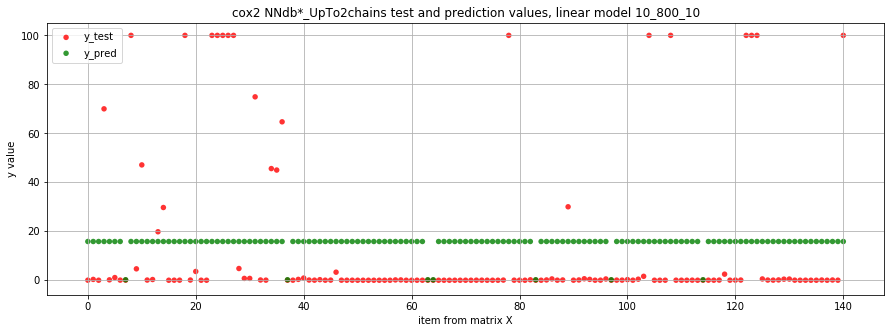

In [581]:
model = make_ordinary_mgua(X=bzr, y=bzr_y, fitted_model_file='cox2/model__10_800_10__cox2_matrix_alphabet_NNdb*_UpTo2chains.json', q=10, c=0.8, it=10, model=LinearRegression(normalize=True), print_num_points=None, figname='er_lit')



In [347]:
pd.DataFrame(model.buf_coef)

,0,1,2,3,4,5,6,7,8,9
0,"[34, 88]","[44, 88]","[50, 99]","[67, 88]","[67, 99]","[71, 88]","[88, 97]","[88, 99]","[88, 114]","[99, 114]"
1,"[34, 1]","[34, 3]","[34, 7]","[34, 8]","[50, 4]","[50, 7]","[67, 7]","[88, 9]","[97, 8]","[99, 1]"
2,"[34, 5]","[34, 6]","[34, 7]","[34, 9]","[41, 2]","[50, 2]","[50, 7]","[65, 3]","[67, 3]","[99, 3]"
3,"[34, 6]","[41, 1]","[41, 2]","[41, 5]","[41, 9]","[50, 9]","[67, 2]","[67, 5]","[67, 9]","[113, 5]"
4,"[37, 7]","[41, 5]","[41, 6]","[41, 7]","[41, 8]","[41, 9]","[44, 3]","[45, 3]","[50, 1]","[50, 6]"
5,"[17, 3]","[26, 3]","[37, 3]","[41, 9]","[49, 3]","[65, 3]","[85, 3]","[113, 3]","[114, 7]","[114, 8]"
6,"[17, 2]","[17, 3]","[17, 7]","[37, 5]","[65, 3]","[65, 7]","[67, 8]","[85, 3]","[114, 2]","[114, 4]"
7,"[17, 3]","[17, 4]","[17, 5]","[17, 6]","[17, 7]","[17, 8]","[17, 9]","[37, 4]","[65, 7]","[85, 9]"
8,"[17, 7]","[17, 8]","[17, 9]","[37, 2]","[37, 6]","[49, 1]","[49, 8]","[65, 3]","[73, 8]","[85, 2]"
9,"[2, 1]","[16, 1]","[17, 6]","[37, 5]","[48, 1]","[49, 3]","[49, 7]","[49, 9]","[63, 1]","[85, 7]"


In [335]:
train_size = int(0.7 * bzr.shape[0])
X_train = bzr[:][:train_size]
y_train = bzr_y[:][:train_size]
X_test = bzr[:][train_size:]
y_test = bzr_y[:][train_size:]

# train_size = int(0.7 * bzr.shape[0])
# rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
# # print(rand_fold)
# X_train = bzr[:].loc[rand_fold]
# y_train = bzr_y[:].loc[rand_fold]
# X_test = bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]
# y_test = bzr_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

In [336]:
res = model.predict(X_test)

In [280]:
len(res)

1

In [337]:
scores = [r2_score(y_test, res[i]) for i in range(len(res))]
scores

[0.05345740441573521,
 0.06173298758050838,
 0.05221266173575234,
 0.04450407213632135,
 0.012542802058241764,
 0.012421103696936608,
 -0.13886986003973179,
 -0.17514015858717613,
 -0.13587501793127243,
 -0.18637434701925004]

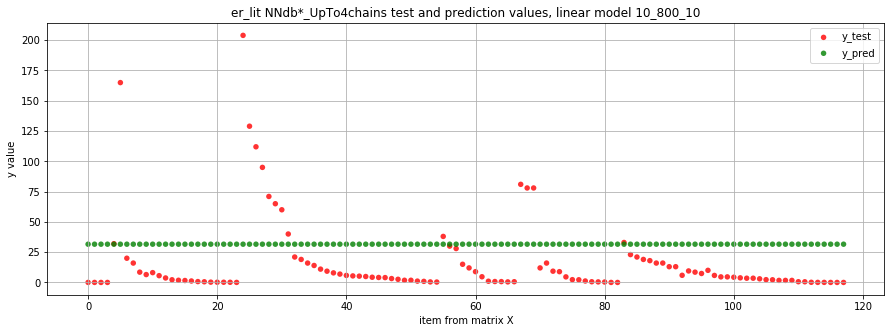

In [283]:
# data = ((np.arange(40, 80), y_test.to_numpy().reshape(-1)[40:80]), (np.arange(40, 80), ridge_soil_pred[2].reshape(-1)[40:80]))
data = ((np.arange(y_test[:].shape[0]), y_test.to_numpy().reshape(-1)[:]), (np.arange(y_test[:].shape[0]), res[scores.index(max(scores))].reshape(-1)[:]))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#         ax.vlines(x[0], x[1], y[1], color = 'r')

plt.title('er_lit NNdb*_UpTo3chains test and prediction values, linear model 10_800_10')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

In [338]:
a = y_test.reset_index()
a['active'] = 0
for i, row in a['RBA_avg'].items():
    if row > 1.0:
        a['active'][i] = 0
#         print(i, row)
    else:
        a['active'][i] = 1

/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [339]:
a

,index,RBA_avg,active
0,275,0.03,1
1,276,0.03,1
2,277,0.01,1
3,278,0.02,1
4,279,32.00,0
...,...,...,...
113,388,0.06,1
114,389,0.06,1
115,390,0.02,1
116,391,0.01,1


In [340]:
pred = res[scores.index(max(scores))]
b = []
for num in pred:
#     print(num[0])
    if num[0] > 1.0:
        b.append(0)
    else:
        b.append(1)

In [341]:
from sklearn.metrics import roc_auc_score

In [342]:
roc_auc_score(a['active'], b)

0.515625

In [17]:
res[scores.index(max(scores))].reshape(-1)[:]

array([65.03955953, 28.46522927,  8.63227253, 45.16730205, 60.96703188,
        2.52348106,  4.55974488,  8.63227253, 24.39270162, 25.39381849,
       24.39270162, 24.39270162, 24.39270162, 24.39270162, 24.39270162,
       20.32017397, 24.39270162, 24.39270162, 24.39270162, 24.39270162,
        8.63227253,  8.63227253,  4.55974488,  6.59600871,  6.59600871,
       65.02101457, 24.39270162, 86.09540164, 24.39270162, 24.39270162,
       24.39270162, 24.39270162, 24.39270162, 24.39270162, 24.39270162,
       24.39270162, 65.00025879, 24.39270162, 24.39270162, 24.39270162,
       24.39270162, 24.39270162, 22.35643779, 24.39270162, 24.39270162,
       24.39270162, 24.39270162, 24.39270162, 18.28391014, 20.32017397,
       20.32017397, 20.32017397, 22.35643779,  0.48721723, 24.39270162,
       24.39270162, 18.24988007, 18.24988007, 24.39270162, 24.39270162,
       60.96703188, 65.03955953, 60.96703188, 60.96703188, 65.03955953,
       65.03955953, 65.03955953, 65.03955953, 65.03955953, 49.23

In [40]:
round_y = []
for i, elem in bzr_y['IC50_uM'].items():
    round_y.append(round(elem))

(array([374.,   9.,  20.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 10 Patch objects>)

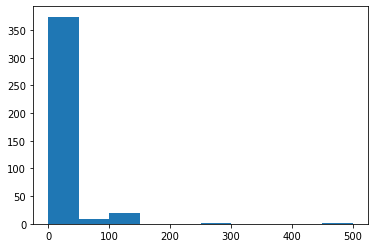

In [47]:
plt.hist(np.array(round_y))

In [52]:

unique, counts = np.unique(np.array(round_y), return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 283]
 [  1  44]
 [  2  15]
 [  3   3]
 [  4   5]
 [  5   6]
 [  6   3]
 [  7   1]
 [  8   1]
 [  9   1]
 [ 10   4]
 [ 11   1]
 [ 12   1]
 [ 13   1]
 [ 24   1]
 [ 25   1]
 [ 26   1]
 [ 32   1]
 [ 39   1]
 [ 50   8]
 [ 54   1]
 [100  20]
 [250   1]
 [500   1]]


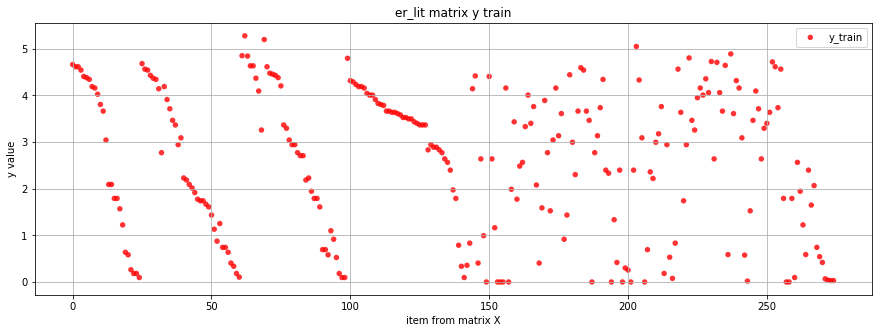

In [343]:
data = ((np.arange(y_train[:].shape[0]), y_train.to_numpy().reshape(-1)[:]), (np.arange(y_test[:].shape[0]), res[scores.index(max(scores))].reshape(-1)[:]))
colors = ("red", "green")
groups = ("y_train", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, np.log(y+1), alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    break
#         ax.vlines(x[0], x[1], y[1], color = 'r')

plt.title('er_lit matrix y train')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

In [157]:
mgua_bzr = mguaJN.MGUA()
mgua_bzr.load_json('bzr/model_10_900_10__bzr_matrix_alphabet_NNdb*_UpTo4chains.json')
res = mgua_bzr.predict(X_test)

In [158]:
pred = res[scores.index(max(scores))]
pred

array([[ 68.87427192],
       [  1.26960257],
       [  1.26960257],
       [132.14856299],
       [ 68.87427192],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [ 39.07064236],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1.26960257],
       [  1

In [159]:
b = []
for num in pred:
#     print(num[0])
    if num[0] > 0.1:
        b.append(0)
    else:
        b.append(1)

In [160]:
roc_auc_score(a['active'], b)

0.4939759036144578

# Кластеризация

In [485]:
bzr = pd.read_csv('er_lit/er_lit_matrix_alphabet_NNdb*_UpTo2chains.csv', sep=',')
bzr_y = pd.read_csv('er_lit/er_lit_y.csv', sep=',')

In [ ]:
for i, elem in bzr_y['IC50_uM'].items():
    bzr_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [486]:
bzr_y  = np.log(bzr_y+1)

In [487]:
train_size = int(0.7 * bzr.shape[0])
X_train = bzr[:][:train_size]
y_train = bzr_y[:][:train_size]
X_test = bzr[:][train_size:]
y_test = bzr_y[:][train_size:]

# train_size = int(0.7 * bzr.shape[0])
# rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
# # print(rand_fold)
# X_train = bzr[:].loc[rand_fold]
# y_train = bzr_y[:].loc[rand_fold]
# X_test = bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]
# y_test = bzr_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

In [453]:
# y_train.to_numpy()

In [496]:
from metric_learn import MLKR
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
import hdbscan
import random

In [488]:
mlkr = MLKR()

In [489]:
mlkr.fit(X_train, y_train.to_numpy())

/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/metric_learn/mlkr.py:181: ChangedBehaviorWarning: Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of 'pca'. If you still want to use PCA as an init, set init='pca'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.
  warnings.warn(msg, ChangedBehaviorWarning)


MLKR(A0='deprecated', init=None, max_iter=1000, n_components=None,
     num_dims='deprecated', preprocessor=None, random_state=None, tol=None,
     verbose=False)

In [490]:
metric_fun = mlkr.get_metric()

In [491]:
# X_dist = pairwise_distances(X_train, metric=metric_fun)
X_dist = pairwise_distances(X_train, metric='euclidean')

In [555]:
# clusters_train = DBSCAN(eps=3.).fit(X_dist)
# clusters_train = KMeans(n_clusters=3).fit(X_dist)
clusters_train = hdbscan.HDBSCAN(min_cluster_size=10, metric='precomputed')
clusters_train.fit(X_dist)
np.unique(clusters_train.labels_)

array([-1,  0,  1])

['bisque', 'darkorange', 'olivedrab']


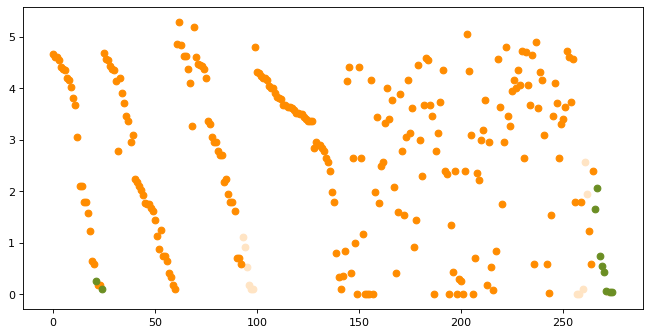

In [556]:
clusters = np.unique(clusters_train.labels_)
# print(clusters.shape, X_train.shape)
yy_train = y_train.copy()
yy_train['cluster'] = clusters_train.labels_
# colours = [plt.cm.tab10(i/float(len(clusters)-1)) for i in range(len(clusters))]
# colours = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'olive', 'cyan']
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(200)
colours = random.choices(all_colors, k=len(clusters))
print(colours)

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(clusters):
    plt.scatter(x=yy_train.loc[yy_train.cluster==category].index, y=yy_train.loc[yy_train.cluster==category]['RBA_avg'], c=colours[i])

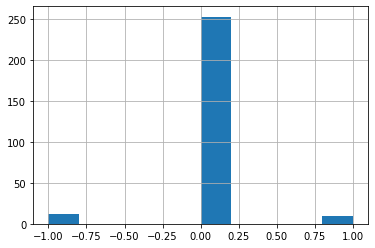

In [557]:
yy_train['cluster'].hist()

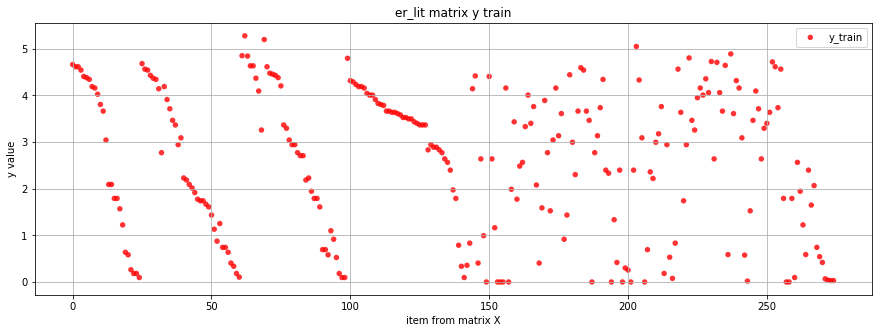

In [387]:
data = ((np.arange(y_train[:].shape[0]), y_train.to_numpy().reshape(-1)[:]), (np.arange(y_test[:].shape[0]), res[scores.index(max(scores))].reshape(-1)[:]))
colors = ("red", "green")
groups = ("y_train", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    break
#         ax.vlines(x[0], x[1], y[1], color = 'r')

plt.title('er_lit matrix y train')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

Text(0.5, 1.0, 'er_lit')

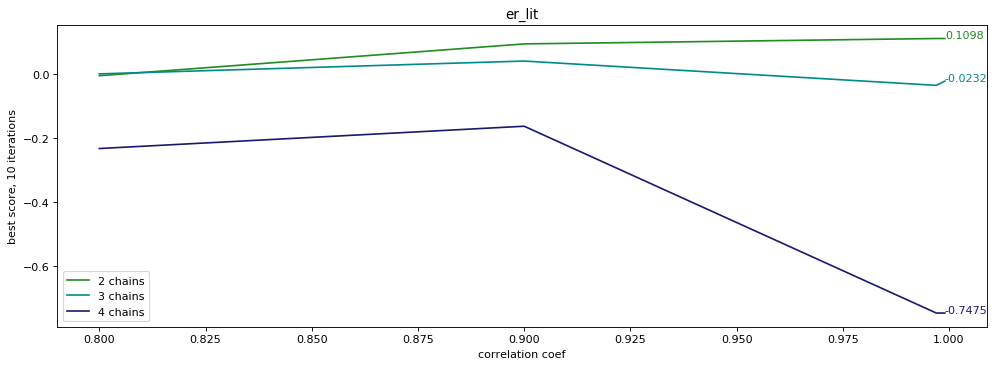

In [575]:
x1 = [0.800, 0.900, 0.997, 0.999]
y2 = [-0.006329067, 0.092965596, 0.109835019759, 0.1098]
y3 = [-0.00064153210, 0.039421768, -0.036497619, -0.0232]
y4 = [-0.233753090, -0.1641462016, -0.74756339, -0.7475]

# Create plot
plt.figure(figsize=(15,5), dpi= 80)

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(7)
colours = random.choices(all_colors, k=3)

plt.plot(x1, y2, c=colours[0], label='2 chains')
plt.text(x1[-1], y2[-1], y2[-1], c=colours[0])
plt.plot(x1, y3, c=colours[1], label='3 chains')
plt.text(x1[-1], y3[-1], y3[-1], c=colours[1])
plt.plot(x1, y4, c=colours[2], label='4 chains')
plt.text(x1[-1], y4[-1], y4[-1], c=colours[2])


plt.ylabel("best score, 10 iterations")
plt.xlabel("correlation coef")

plt.legend()
plt.title('er_lit')

Text(0.5, 1.0, 'cox2')

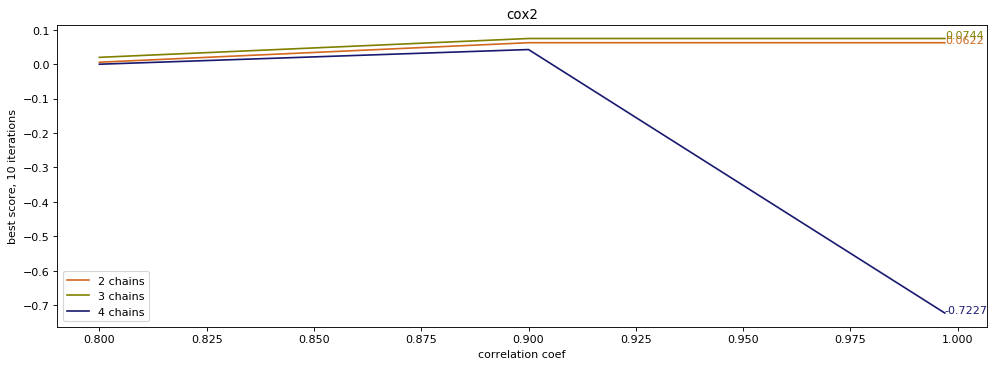

In [589]:
x1 = [0.800, 0.900, 0.997]
y2 = [0.0055377, 0.062236, 0.0622]
y3 = [0.019718, 0.074413, 0.0744]
y4 = [-0.0002476, 0.0423558, -0.7227]

# Create plot
plt.figure(figsize=(15,5), dpi= 80)

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(14)
colours = random.choices(all_colors, k=3)

plt.plot(x1, y2, c=colours[0], label='2 chains')
plt.text(x1[-1], y2[-1], y2[-1], c=colours[0])
plt.plot(x1, y3, c=colours[1], label='3 chains')
plt.text(x1[-1], y3[-1], y3[-1], c=colours[1])
plt.plot(x1, y4, c=colours[2], label='4 chains')
plt.text(x1[-1], y4[-1], y4[-1], c=colours[2])


plt.ylabel("best score, 10 iterations")
plt.xlabel("correlation coef")

plt.legend()
plt.title('cox2')

Text(0.5, 1.0, 'bzr')

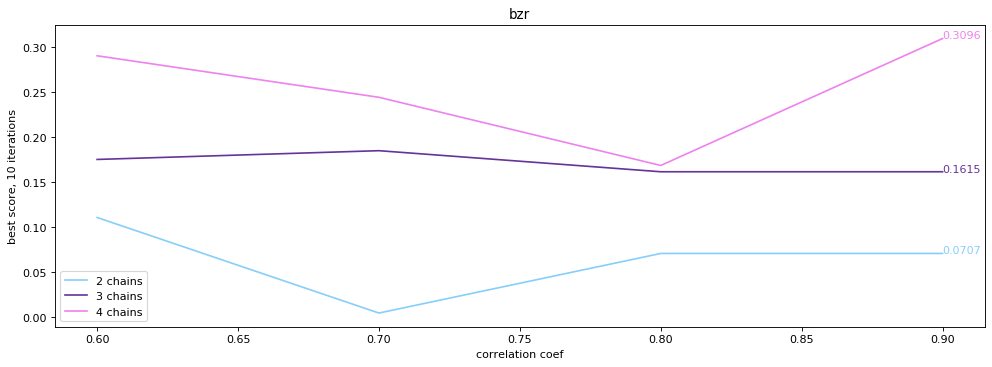

In [592]:
x1 = [0.600, 0.700, 0.800, 0.900]
y2 = [0.11067, 0.004466, 0.0707, 0.0707]
y3 = [0.17518, 0.18492, 0.1615, 0.1615]
y4 = [0.290408, 0.24425, 0.1685, 0.3096]

# Create plot
plt.figure(figsize=(15,5), dpi= 80)

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(17)
colours = random.choices(all_colors, k=3)

plt.plot(x1, y2, c=colours[0], label='2 chains')
plt.text(x1[-1], y2[-1], y2[-1], c=colours[0])
plt.plot(x1, y3, c=colours[1], label='3 chains')
plt.text(x1[-1], y3[-1], y3[-1], c=colours[1])
plt.plot(x1, y4, c=colours[2], label='4 chains')
plt.text(x1[-1], y4[-1], y4[-1], c=colours[2])


plt.ylabel("best score, 10 iterations")
plt.xlabel("correlation coef")

plt.legend()
plt.title('bzr')